### Utility functions

In [4]:
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import requests
import json
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from torchvision.models import vgg16, VGG16_Weights
from torchvision.transforms.functional import affine

In [42]:
print("PyTorch Version:", torch.__version__)
print("TorchVision Version:", torchvision.__version__)

PyTorch Version: 2.4.0.dev20240403
TorchVision Version: 0.19.0.dev20240403


In [43]:
# Load the VGG16 model with predefined weights
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model.eval()  # Set the model to evaluation mode

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
# Load ImageNet Class Index and create idx2label
imagenet_class_index_url = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
class_idx = json.loads(requests.get(imagenet_class_index_url).text)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [7]:
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

# GRADIENT BASED PIXEL ATTRIBUTION

In [8]:
def predict_image(model, image):
    output = model(image)
    _, preds = torch.max(output, 1)
    return preds.item()

def print_predicted_class(model, image):
    pred_class = predict_image(model, image)
    print(f"Predicted Class: {idx2label[pred_class]} ({pred_class})")
    return pred_class

In [9]:
image_paths = [
    './images/lion.jpg',
    './images/beagle.jpg',
    './images/airliner.jpg',
    './images/banana.jpg',
    './images/coffeemug.jpg',
    './images/volcano.jpg'
]

## GRAD-CAM

In [10]:
class VGG16GradCAM(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.features = pretrained_model.features
        self.avgpool = pretrained_model.avgpool
        self.classifier = pretrained_model.classifier
        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        # Register hook to capture gradients
        h = x.register_hook(self.activations_hook)
        x = self.avgpool(x)
        x = x.view((x.size(0), -1))
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features(x)

cam_model = VGG16GradCAM(model)

In [11]:
def grad_cam(model, image, target_class):
    model_output = model(image)
    model.zero_grad()
    one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
    one_hot_output[0][target_class] = 1
    model_output.backward(gradient=one_hot_output)

    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(image).detach()

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap.numpy()

In [12]:
def display_heatmap(image_path, heatmap, alpha=0.5):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    heatmap = Image.fromarray(np.uint8(255 * heatmap))
    heatmap = heatmap.resize(img.size)
    heatmap = np.asarray(heatmap)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=alpha)
    plt.axis('off')
    plt.show()

Predicted Class: lion (291)


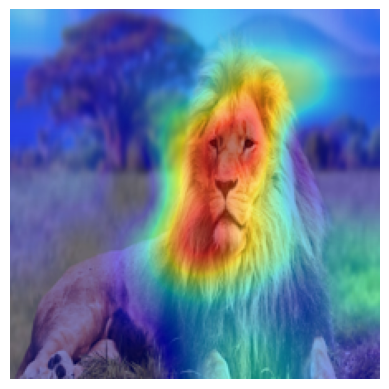

Predicted Class: beagle (162)


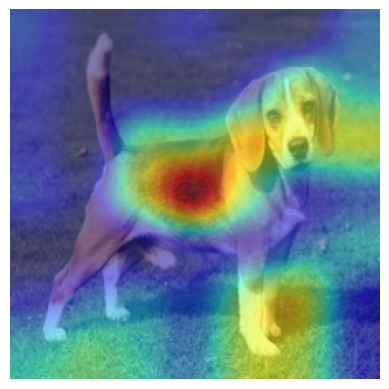

Predicted Class: airliner (404)


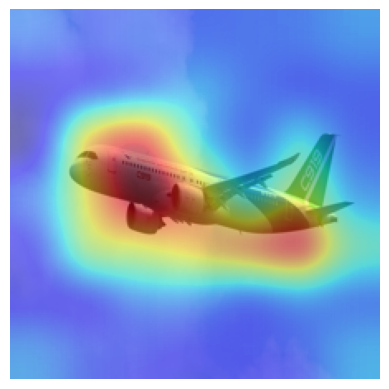

Predicted Class: banana (954)


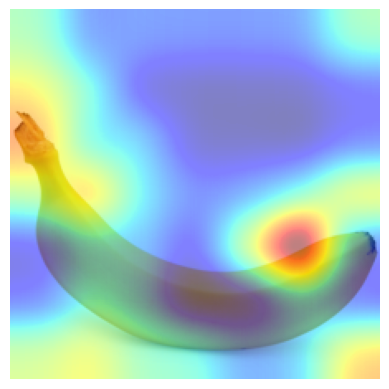

Predicted Class: coffee_mug (504)


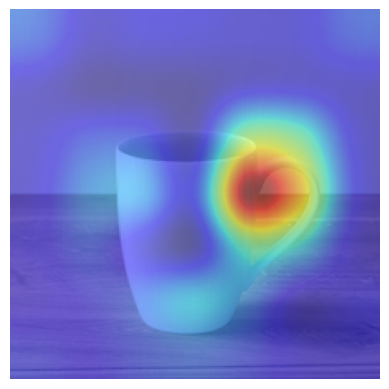

Predicted Class: volcano (980)


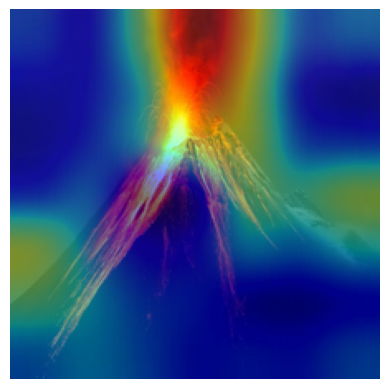

In [13]:
for image_path in image_paths:
    image = preprocess_image(image_path)

    # Predict the class
    pred_class = predict_image(model, image)
    print_predicted_class(model, image)

    heatmap = grad_cam(cam_model, image, pred_class)
    display_heatmap(image_path, heatmap)

## Guided backpropagation

In [14]:
class VGG16GuidedBackprop(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.model = pretrained_model
        self.model.eval()
        # override ReLU
        for module in self.model.modules():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(self.relu_backward_hook)

    def relu_backward_hook(self, module, grad_in, grad_out):
        # negative gradient changed it to zero
        if isinstance(module, nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)

    def forward(self, x):
        return self.model(x)

    def generate_gradients(self, input_image, target_class):
        # reset gradients
        input_image.grad = None
        model_output = self.forward(input_image)
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0, target_class] = 1
        model_output.backward(gradient=one_hot_output)
        return input_image.grad

guided_bp_model = VGG16GuidedBackprop(model)

In [15]:
def display_saliency(image_path, saliency):
    saliency = saliency.squeeze()  # Remove batch dimension if present
    img = Image.open(image_path)
    img = img.resize((224, 224))
    saliency = np.abs(saliency).max(axis=0)  # Collapse channel dimension

    plt.imshow(img)
    plt.imshow(saliency, cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.show()

/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


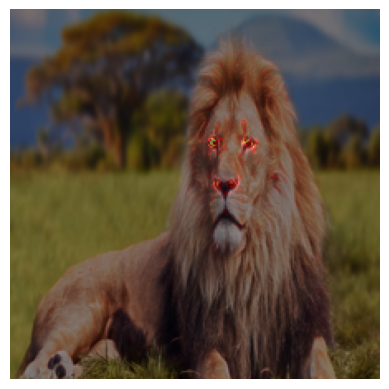

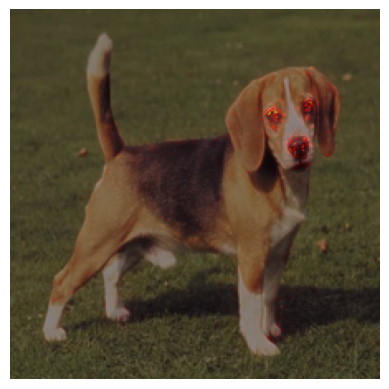

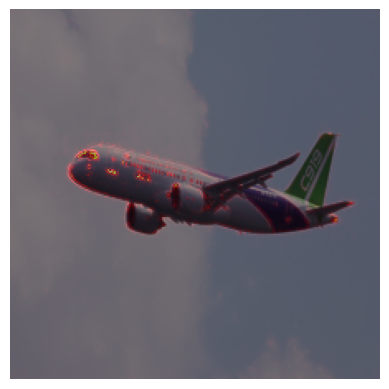

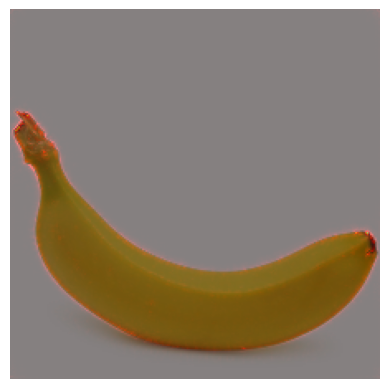

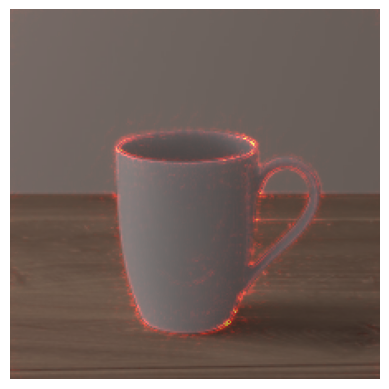

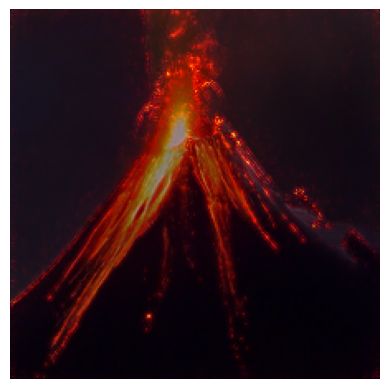

In [16]:
for image_path in image_paths:
    image = preprocess_image(image_path)
    image.requires_grad = True
    pred_class = predict_image(model, image)
    
    saliency = guided_bp_model.generate_gradients(image, pred_class)
    if saliency is not None:
        saliency = saliency.cpu().numpy()  # Move tensor to CPU and convert to NumPy
        display_saliency(image_path, saliency)
    else:
        print("No gradients were calculated.")

## Guided GRAD-CAM

In [17]:
def guided_grad_cam(grad_cam_heatmap, guided_backprop_grads):
    guided_backprop_grads = guided_backprop_grads.squeeze().numpy()

    # resize heatmap for matching dimensions
    heatmap_resized = np.array(Image.fromarray(grad_cam_heatmap.squeeze()).resize(
        guided_backprop_grads.shape[1:], Image.BILINEAR))

    heatmap_expanded = np.expand_dims(heatmap_resized, axis=0)

    # element wise multiplication
    cam_gb = np.multiply(guided_backprop_grads, heatmap_expanded)
    
    # normalize to range 0-1
    cam_gb -= cam_gb.min()
    cam_gb /= cam_gb.max()
    
    return cam_gb

In [18]:
def display_guided_grad_cam(image_path, cam_gb):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    
    plt.imshow(cam_gb[0], cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.show()

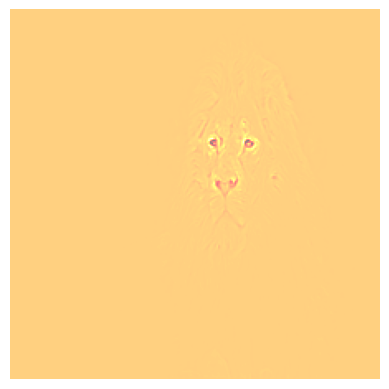

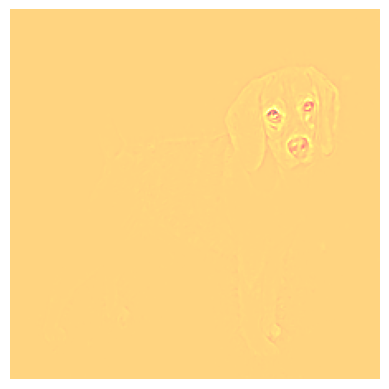

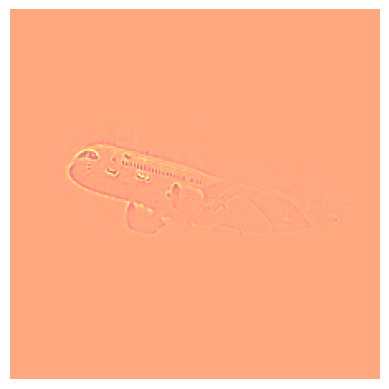

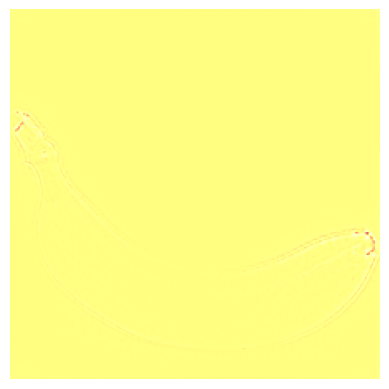

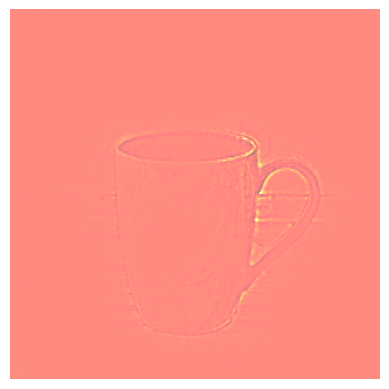

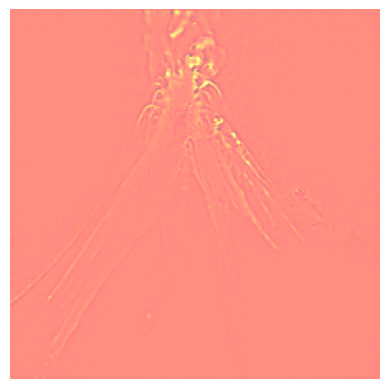

In [19]:
for image_path in image_paths:
    image = preprocess_image(image_path)
    image.requires_grad = True

    # Get predictions and heatmaps for Grad-CAM
    cam_model = VGG16GradCAM(model)
    pred_class = predict_image(model, image)
    heatmap = grad_cam(cam_model, image, pred_class)

    # Get gradients for Guided Backpropagation
    guided_bp_model = VGG16GuidedBackprop(model)
    guided_grads = guided_bp_model.generate_gradients(image, pred_class)

    # Combine both techniques to get Guided Grad-CAM
    cam_gb = guided_grad_cam(heatmap, guided_grads)
    
    # Display results
    display_guided_grad_cam(image_path, cam_gb)

## Guided backpropagation + SmoothGrad

In [20]:
class VGG16GuidedBackpropSmoothGrad(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()
        for module in self.model.modules():
            if isinstance(module, torch.nn.ReLU):
                module.register_backward_hook(self.relu_backward_hook)

    def relu_backward_hook(self, module, grad_in, grad_out):
        return (torch.clamp(grad_in[0], min=0.0),)

    def forward(self, x):
        return self.model(x)

    def generate_smooth_grad(self, input_image, target_class, n_samples=50, noise_level=0.15):
        input_image.requires_grad = True
        smooth_grad = None

        for i in range(n_samples):
            noise = torch.randn(input_image.size()) * noise_level
            noisy_image = input_image + noise
            output = self.forward(noisy_image)
            self.model.zero_grad()
            one_hot_output = torch.zeros_like(output)
            one_hot_output[0, target_class] = 1
            output.backward(gradient=one_hot_output)
            grad = input_image.grad.data.clone()
            input_image.grad.data.zero_()

            if smooth_grad is None:
                smooth_grad = grad
            else:
                smooth_grad += grad

        smooth_grad /= n_samples
        return smooth_grad

gb_smooth_model = VGG16GuidedBackpropSmoothGrad(model)

In [21]:
# Display function adjusted for direct use with tensors
def display_saliency(image_path, saliency):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    # plt.imshow(img)
    plt.imshow(saliency, cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


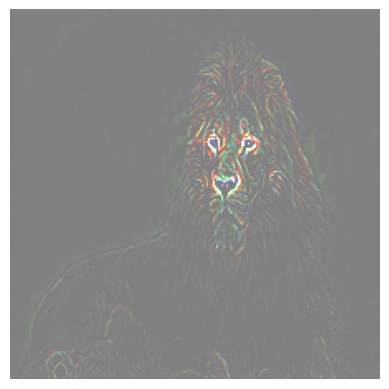

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


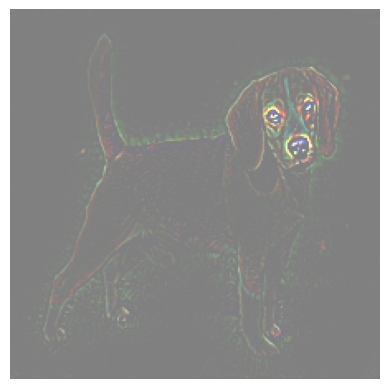

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


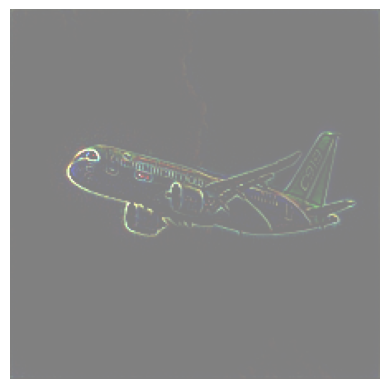

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


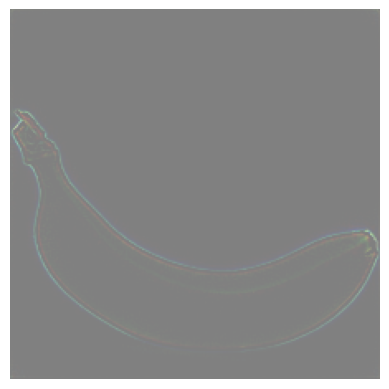

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


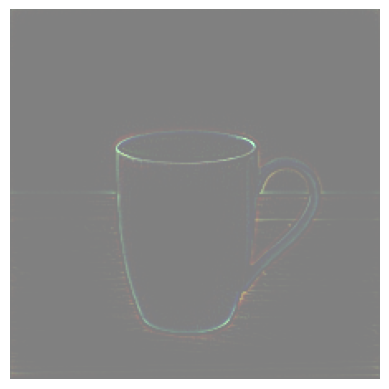

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


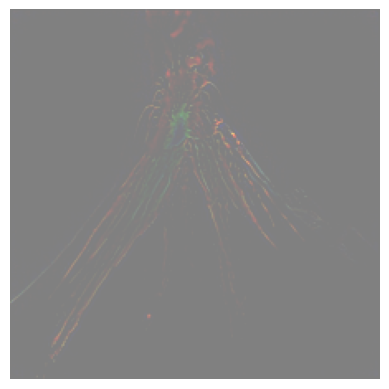

In [22]:
for image_path in image_paths:
    image = preprocess_image(image_path)
    pred_class = predict_image(model, image)
    smooth_grad = gb_smooth_model.generate_smooth_grad(image, pred_class)
    
    # Convert tensor to numpy array and remove unnecessary dimensions
    smooth_grad_np = smooth_grad.squeeze().cpu().numpy()
    smooth_grad_np = np.transpose(smooth_grad_np, (1, 2, 0))
    display_saliency(image_path, smooth_grad_np)

## Guided backpropagation + SmoothGrad + Grad-CAM

In [23]:
def combine_grad_cam_and_guided_bp(grad_cam_heatmap, guided_backprop_grads):
    # grad_cam_heatmap is 2D
    heatmap_resized = grad_cam_heatmap.squeeze()
    if len(heatmap_resized.shape) != 2:
        raise ValueError("Heatmap must be a 2D array.")

    # resize heatmap
    heatmap_image = Image.fromarray((heatmap_resized * 255).astype(np.uint8))
    heatmap_resized = np.array(heatmap_image.resize(
        guided_backprop_grads.shape[:2], Image.BILINEAR))

    if len(heatmap_resized.shape) != 2:
        raise ValueError("Resized heatmap must be a 2D array.")

    # element-wise multiplication
    combined_output = guided_backprop_grads * heatmap_resized[:, :, np.newaxis]
    combined_output -= combined_output.min()
    combined_output /= combined_output.max()
    return combined_output

In [24]:
def display_combination(image_path, cam_gb):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    
    if len(cam_gb.shape) == 3:
        # remove the singleton dimension if necessary
        if cam_gb.shape[2] == 1:
            cam_gb = cam_gb.squeeze(axis=2)
        elif cam_gb.shape[2] == 3:
            # convert to grayscale by averaging the channels
            cam_gb = np.mean(cam_gb, axis=2)

    # plt.imshow(np.array(img))
    plt.imshow(cam_gb, cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.show()

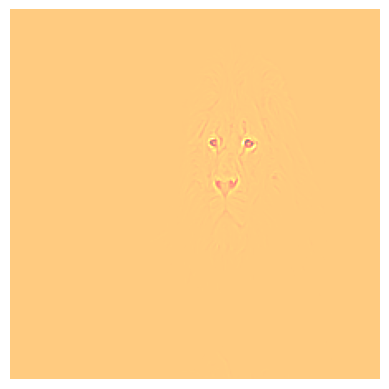

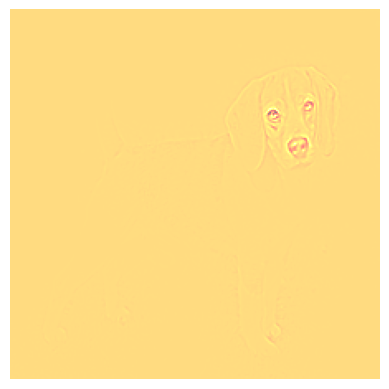

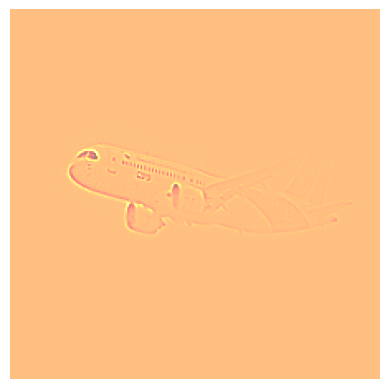

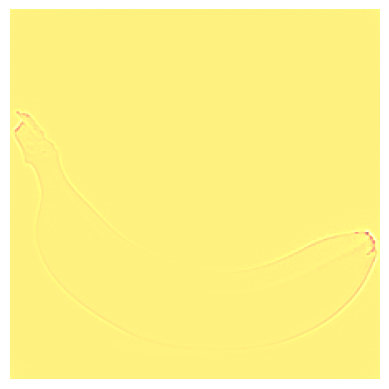

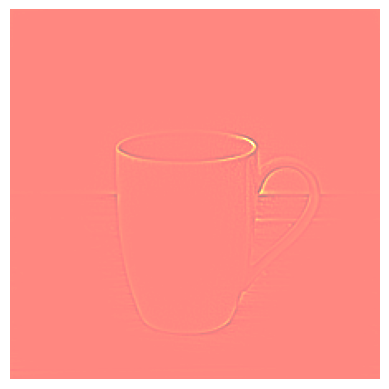

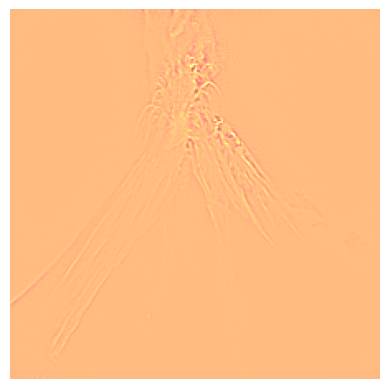

In [25]:
for image_path in image_paths:
    image = preprocess_image(image_path)
    pred_class = predict_image(model, image)

    # Grad-CAM
    grad_cam_heatmap = grad_cam(cam_model, image, pred_class)
    
    # Guided Backprop Smooth Grad
    guided_grad = gb_smooth_model.generate_smooth_grad(image, pred_class)
    # tensor to numpy for processing
    guided_grad_np = guided_grad.squeeze().cpu().numpy()
    guided_grad_np = np.transpose(guided_grad_np, (1, 2, 0))

    # Combine the outputs
    combined_output = combine_grad_cam_and_guided_bp(grad_cam_heatmap, guided_grad_np)
    
    display_combination(image_path, combined_output)

## Adversarial Petrebution and Pixel Attribiution

Before attack:
Predicted Class: lion (291)
After attack:
Predicted Class: lion (291)


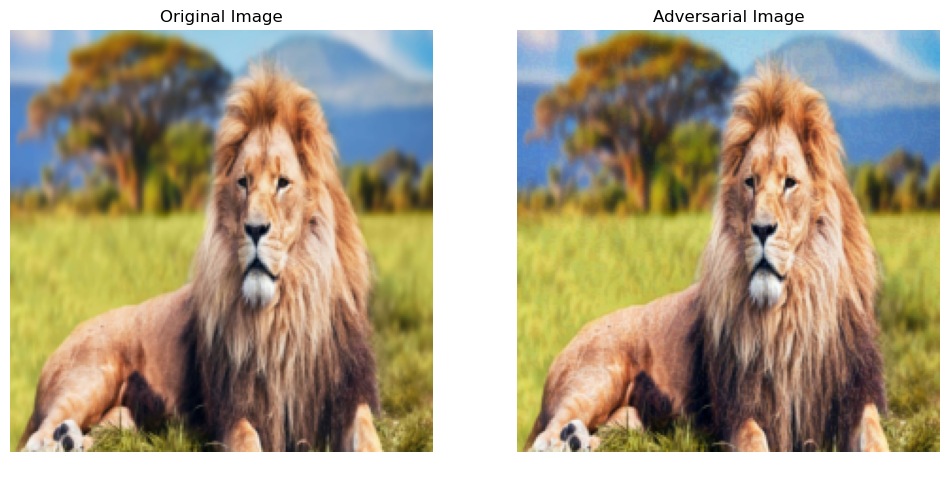

In [26]:
# Function to visualize images
def imshow(img, title=None):
    img = img.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)


image_path = './images/lion.jpg'  # Update this path to your image
input_tensor = preprocess_image(image_path)
print("Before attack:")
pred_class = print_predicted_class(model, input_tensor)

# generate Adversarial Example Using FGSM
epsilon = 0.05
adv_tensor = fast_gradient_method(model, input_tensor, epsilon, np.inf, targeted=False)

print("After attack:")
adv_pred_class = print_predicted_class(model, adv_tensor)


# visualiziation
plt.figure(figsize=(12, 6))
plt.axis('off')
plt.subplot(1, 2, 1)
plt.axis('off')
imshow(input_tensor[0], title='Original Image')
plt.subplot(1, 2, 2)
plt.axis('off')
imshow(adv_tensor[0], title='Adversarial Image')
plt.show()

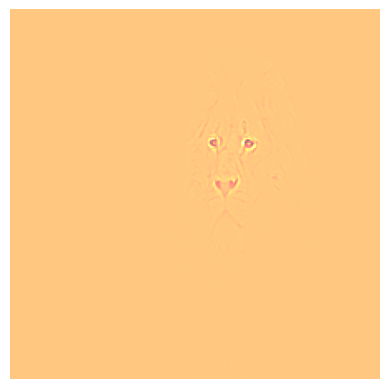

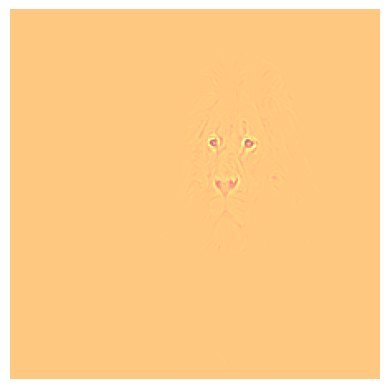

In [27]:
# Assuming grad_cam and generate_smooth_grad are defined correctly elsewhere
def process_and_display(input_tensor, pred_class, image_path):
    # Create a leaf tensor with requires_grad enabled
    input_tensor_leaf = input_tensor.clone().detach()
    input_tensor_leaf.requires_grad = True

    # Grad-CAM
    grad_cam_heatmap = grad_cam(cam_model, input_tensor_leaf, pred_class)
    
    # Guided Backprop Smooth Grad
    guided_grad = gb_smooth_model.generate_smooth_grad(input_tensor_leaf, pred_class)
    # Convert tensor to numpy for processing
    guided_grad_np = guided_grad.squeeze().cpu().numpy()
    guided_grad_np = np.transpose(guided_grad_np, (1, 2, 0))

    # Combine the outputs
    combined_output = combine_grad_cam_and_guided_bp(grad_cam_heatmap, guided_grad_np)

    display_combination(image_path, combined_output)


process_and_display(input_tensor, pred_class, image_path)
process_and_display(adv_tensor, adv_pred_class, image_path)

# FEATURE VISUALIZATION

## Activation Maximization

In [44]:
print("Class index for 'Hen':", idx2label.index("hen"))

Class index for 'Hen': 8


In [45]:
import torch
print(torch.__version__)

2.4.0.dev20240403


In [46]:
def deprocess_image(tensor):
    tensor = tensor.squeeze().detach().cpu()
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225])[:, None, None] + torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    tensor = torch.clamp(tensor, 0, 1)
    return transforms.ToPILImage()(tensor)

In [47]:
input_img = torch.randn(1, 3, 224, 224, requires_grad=True)
optimizer = optim.Adam([input_img], lr=0.1)

for i in range(300):
    optimizer.zero_grad()
    output = model(input_img)
    channel_to_maximize = 8
    # summing all the elements in the class index to maximize
    loss = -output[:, channel_to_maximize].sum()
    loss.backward()
    optimizer.step()

    input_img.data = torch.clamp(input_img.data, -2, 2)

    if i % 50 == 0:
        print(f'Iteration {i}, Loss: {loss.item()}')

Iteration 0, Loss: -1.0441597700119019
Iteration 50, Loss: -701.3516235351562
Iteration 100, Loss: -1049.451904296875
Iteration 150, Loss: -1206.744384765625
Iteration 200, Loss: -1289.4268798828125
Iteration 250, Loss: -1339.5008544921875


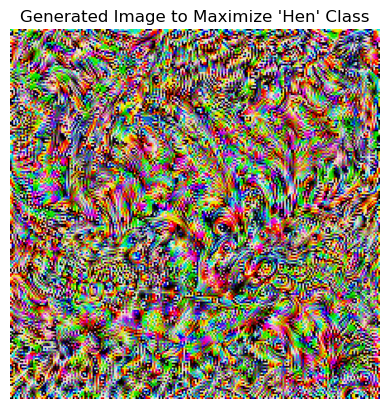

In [48]:
final_img = deprocess_image(input_img)
plt.imshow(final_img)
plt.axis('off')
plt.title("Generated Image to Maximize 'Hen' Class")
plt.show()

## Add new enhancments (TV + Random shift)

In [49]:
def total_variance_loss(img):
    pixel_diff_x = (img[:, :, 1:] - img[:, :, :-1])**2
    pixel_diff_y = (img[:, 1:, :] - img[:, :-1, :])**2
    
    return pixel_diff_x.sum() + pixel_diff_y.sum()

In [50]:
def random_shift(img):
    x_shift = torch.randint(-32, 33, (1,), dtype=torch.int32).item()
    y_shift = torch.randint(-32, 33, (1,), dtype=torch.int32).item()
    return torch.roll(img, shifts=(x_shift, y_shift), dims=(2, 3))

In [51]:
def optimize_image():
    # Initialize a noise
    input_img = torch.rand(1, 3, 224, 224, requires_grad=True)
    optimizer = optim.Adam([input_img], lr=0.1)

    for i in range(300):
        optimizer.zero_grad()
        
        # random shift
        shifted_img = random_shift(input_img)

        output = model(shifted_img)
        class_loss = -output[0, 8]

        # tv
        tv_loss = total_variance_loss(shifted_img)
        lambda_tv = 0.07
        
        # total loss
        loss = class_loss + lambda_tv * tv_loss
        
        loss.backward()
        optimizer.step()
        input_img.data = torch.clamp(input_img.data, -2, 2)

    return input_img

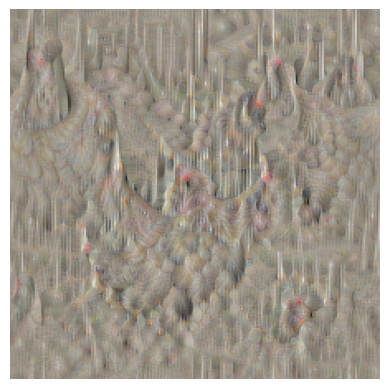

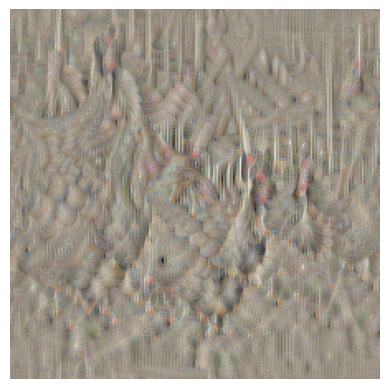

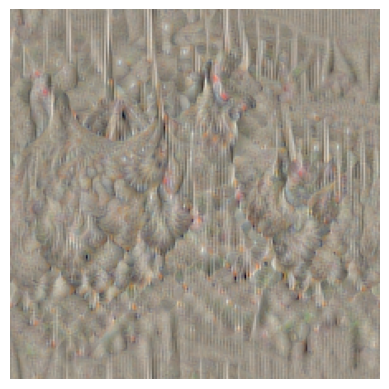

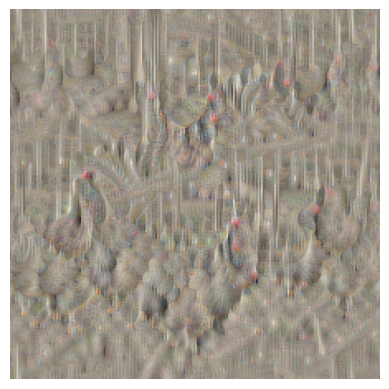

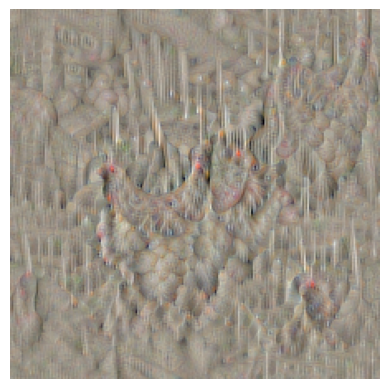

In [52]:
for i in range(5):
    optimized_img = optimize_image()
    final_img = deprocess_image(optimized_img)
    plt.figure()
    plt.axis('off')
    plt.imshow(final_img)
    plt.show()